In [1]:
# If running in a fresh Colab environment, uncomment this:
!pip install pytorch-tabnet wget #imp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=42bc2ae8234985e1e516631a30c6863736356a35f915ac276c6cdbd8d0c6e195
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [23]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import json

from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# Detect whether we're running in Colab
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Colab: mount Google Drive and point PROJECT_ROOT current working directory
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=False)

    PROJECT_ROOT = Path("/content/drive/My Drive/SH").resolve()
    DATA_DIR = PROJECT_ROOT / "data"
else:
    # Local / non-Colab: infer paths from src/paths.py
    from src.paths import get_project_paths

    paths = get_project_paths()
    PROJECT_ROOT = paths["PROJECT_ROOT"]
    DATA_DIR = paths["DATA_DIR"]

# Ensure PROJECT_ROOT is on sys.path so "src" is importable
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

print("IN_COLAB    :", IN_COLAB)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR    :", DATA_DIR)
print("PROC_DIR    :", PROC_DIR)

# Project helpers
from src.preprocessing import fill_numeric_with_train_median
from src.io_utils import load_prep_summary
from src.targets import backtransform
from src.metrics import regression_metrics

#%load_ext autoreload

#%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IN_COLAB    : True
PROJECT_ROOT: /content/drive/My Drive/SH
DATA_DIR    : /content/drive/My Drive/SH/data
PROC_DIR    : /content/drive/My Drive/SH/data/processed


## Load prepared tabular-only inputs

In [3]:
train_path = PROC_DIR / "train_multimodal.csv"
val_path   = PROC_DIR / "val_multimodal.csv"
test_path  = PROC_DIR / "test_multimodal.csv"

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Val shape  :", val_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (143643, 27)
Val shape  : (17955, 27)
Test shape : (17956, 27)


,sold_price,log_sold_price,description_text,beds,full_baths,half_baths,sqft,year_built,days_on_mls,lot_sqft,...,parking_garage,new_construction,stories,county,sale_year,sale_date,property_id,listing_id,mls,mls_id
0,1475000.0,14.204169,Excellent investment and / or primary residenc...,6.0,4.0,NaN,NaN,1964.0,48.0,5227.0,...,2.0,False,2.0,Essex,2024,2024-07-25,9859620388,2968228851,GSNJ,3906230
1,385000.0,12.861001,UNDER CONTRACT CONTINUE TO SHOW. This charming...,3.0,1.0,NaN,1108.0,1970.0,NaN,7841.0,...,1.0,False,1.0,Ocean,2023,2023-07-20,5713444613,2956792349,MONJ,22316422
2,245000.0,12.409018,GREAT VALUE on this Cherry and Bright Two Stor...,4.0,3.0,1.0,2408.0,2013.0,NaN,9894.0,...,2.0,False,2.0,Atlantic,2019,2019-05-15,5288556922,652998038,ACNJ,519913
3,335000.0,12.721889,HIGHEST AND BEST RECEIVED AND PRESENTED TO SEL...,3.0,2.0,1.0,NaN,NaN,39.0,9000.0,...,NaN,True,2.0,Atlantic,2023,2023-10-31,6546839515,2959875238,ACNJ,578042
4,520000.0,13.161586,"WELCOME! This 4 bedroom, 2 1/2 bath colonial o...",4.0,2.0,1.0,2272.0,1979.0,NaN,NaN,...,2.0,False,2.0,Burlington,2023,2023-12-27,5172261779,2960919340,PHPA,NJBL2054934


## Load prep summary and define target / features

In [6]:
summary_path = PROC_DIR / "multimodal_prep_summary.json"
with open(summary_path, "r") as f:
    prep_summary = json.load(f)

print(json.dumps(prep_summary["criteria"], indent=2))

{
  "target_column": "sold_price",
  "log_target_column": "log_sold_price",
  "text_min_length": 30,
  "split_type": "random",
  "train_frac": 0.8,
  "val_frac": 0.1,
  "test_frac": 0.1,
  "random_state": 42,
  "numeric_features": [
    "beds",
    "full_baths",
    "half_baths",
    "sqft",
    "year_built",
    "days_on_mls",
    "lot_sqft",
    "hoa_fee",
    "fed_funds_rate"
  ],
  "categorical_features": [
    "city",
    "state",
    "zip_code",
    "status",
    "style",
    "parking_garage",
    "new_construction",
    "stories",
    "county"
  ]
}


# Define categorical features for categorical embeddings

In [7]:
TARGET_RAW_COL = prep_summary["criteria"]["target_column"]
TARGET_LOG_COL = prep_summary["criteria"]["log_target_column"]

NUMERIC_FEATURES = prep_summary["criteria"]["numeric_features"]
CATEGORICAL_FEATURES = prep_summary["criteria"]["categorical_features"]

# Keep only columns that are actually present
NUMERIC_FEATURES = [c for c in NUMERIC_FEATURES if c in train_df.columns]
CATEGORICAL_FEATURES = [c for c in CATEGORICAL_FEATURES if c in train_df.columns]

# Remove leakage HERE
LEAKY = {"price_per_sqft"}
NUMERIC_FEATURES = [c for c in NUMERIC_FEATURES if c not in LEAKY]

FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

print("Target (raw):", TARGET_RAW_COL)
print("Target (log):", TARGET_LOG_COL)
print("Numeric features (filtered, leakage-safe):", NUMERIC_FEATURES)
print("Categorical features (filtered):", CATEGORICAL_FEATURES)
print("Total features:", len(FEATURES))

Target (raw): sold_price
Target (log): log_sold_price
Numeric features (filtered, leakage-safe): ['beds', 'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls', 'lot_sqft', 'hoa_fee', 'fed_funds_rate']
Categorical features (filtered): ['city', 'state', 'zip_code', 'status', 'style', 'parking_garage', 'new_construction', 'stories', 'county']
Total features: 18


# Simple preprocessing
- Fill numeric missing values using train medians.
- Ordinal-encode categorical features using train mapping (with an explicit UNKNOWN index for unseen categories).


In [8]:
def fill_numeric_with_train_median(train_df, other_dfs, numeric_cols):
    med = train_df[numeric_cols].median(numeric_only=True)
    train_df[numeric_cols] = train_df[numeric_cols].fillna(med)
    for df in other_dfs:
        df[numeric_cols] = df[numeric_cols].fillna(med)
    return med

def fit_safe_category_maps(train_df, cat_cols):
    """
    Fit per-column mapping on train; reserve last index for UNKNOWN.
    Returns:
      maps: dict[col] -> dict[str] -> int
      dims: dict[col] -> int (num_categories + 1 for UNKNOWN)
    """
    maps = {}
    dims = {}
    for c in cat_cols:
        s = train_df[c].astype("string").fillna("NA").astype(str)
        uniq = pd.Index(s.unique())
        mapping = {k: i for i, k in enumerate(uniq.tolist())}
        maps[c] = mapping
        dims[c] = len(mapping) + 1  # +1 for UNKNOWN
    return maps, dims

def apply_safe_category_maps(df, cat_cols, maps, dims):
    for c in cat_cols:
        s = df[c].astype("string").fillna("NA").astype(str)
        unk = dims[c] - 1
        df[c] = s.map(maps[c]).fillna(unk).astype(int)
    return df

# 1) Numeric fill
_ = fill_numeric_with_train_median(train_df, [val_df, test_df], NUMERIC_FEATURES)

# 2) Categorical encode
cat_maps, cat_dims_by_col = fit_safe_category_maps(train_df, CATEGORICAL_FEATURES)
train_df = apply_safe_category_maps(train_df, CATEGORICAL_FEATURES, cat_maps, cat_dims_by_col)
val_df   = apply_safe_category_maps(val_df,   CATEGORICAL_FEATURES, cat_maps, cat_dims_by_col)
test_df  = apply_safe_category_maps(test_df,  CATEGORICAL_FEATURES, cat_maps, cat_dims_by_col)

# TabNet needs categorical indices and dims aligned to FEATURE order
cat_idxs = [FEATURES.index(c) for c in CATEGORICAL_FEATURES]
cat_dims = [cat_dims_by_col[c] for c in CATEGORICAL_FEATURES]

print("Number of categorical features:", len(cat_idxs))
print("Example cat idxs:", cat_idxs[:10])
print("Example cat dims:", cat_dims[:10])


Number of categorical features: 9
Example cat idxs: [9, 10, 11, 12, 13, 14, 15, 16, 17]
Example cat dims: [868, 2, 613, 2, 3, 28, 3, 11, 27]


# Build numpy matrices
We train on the log target (e.g., `log_sold_price`) to stabilize regression.


In [9]:
X_train = train_df[FEATURES].to_numpy(dtype=np.float32)
X_val   = val_df[FEATURES].to_numpy(dtype=np.float32)
X_test  = test_df[FEATURES].to_numpy(dtype=np.float32)

y_train = train_df[TARGET_LOG_COL].to_numpy(dtype=np.float32).reshape(-1, 1)
y_val   = val_df[TARGET_LOG_COL].to_numpy(dtype=np.float32).reshape(-1, 1)
y_test  = test_df[TARGET_LOG_COL].to_numpy(dtype=np.float32).reshape(-1, 1)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (143643, 18) y_train: (143643, 1)
X_val  : (17955, 18) y_val  : (17955, 1)
X_test : (17956, 18) y_test : (17956, 1)


# Network parameters
We configure TabNet with categorical embeddings, early stopping, and regression loss.


In [12]:
tabnet_params = dict(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    mask_type="entmax",
)

model = TabNetRegressor(
    **tabnet_params,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=8,
    seed=0,
    verbose=10,
    device_name="cuda" if torch.cuda.is_available() else "cpu",
)

model

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


TabNetRegressor(n_d=32, n_a=32, n_steps=5, gamma=1.5, cat_idxs=[9, 10, 11, 12, 13, 14, 15, 16, 17], cat_dims=[868, 2, 613, 2, 3, 28, 3, 11, 27], cat_emb_dim=[8, 8, 8, 8, 8, 8, 8, 8, 8], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.0001, seed=0, clip_value=1, verbose=10, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02, 'weight_decay': 1e-05}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=None, output_dim=None, device_name='cuda', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

# Training
We fit TabNet using train/val splits and early stopping.


In [13]:
max_epochs = 200
patience = 30
batch_size = 1024
virtual_batch_size = 128

model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=["train", "val"],
    eval_metric=["rmse"],
    max_epochs=max_epochs,
    patience=patience,
    batch_size=batch_size,
    virtual_batch_size=virtual_batch_size,
    num_workers=2,
    drop_last=False,
)


epoch 0  | loss: 3.94032 | train_rmse: 5.1942  | val_rmse: 5.09998 |  0:00:21s
epoch 10 | loss: 0.10873 | train_rmse: 0.30687 | val_rmse: 0.31182 |  0:03:11s
epoch 20 | loss: 0.10425 | train_rmse: 0.33099 | val_rmse: 0.33745 |  0:05:41s
epoch 30 | loss: 0.12417 | train_rmse: 0.33228 | val_rmse: 0.337   |  0:08:05s
epoch 40 | loss: 0.09135 | train_rmse: 0.27598 | val_rmse: 0.28502 |  0:10:30s
epoch 50 | loss: 0.08565 | train_rmse: 0.27296 | val_rmse: 0.28338 |  0:13:05s
epoch 60 | loss: 0.0871  | train_rmse: 0.31301 | val_rmse: 0.32133 |  0:15:32s
epoch 70 | loss: 0.08219 | train_rmse: 0.29044 | val_rmse: 0.29965 |  0:17:57s
epoch 80 | loss: 0.08623 | train_rmse: 0.29069 | val_rmse: 0.30022 |  0:20:18s
epoch 90 | loss: 0.08075 | train_rmse: 0.2685  | val_rmse: 0.27896 |  0:22:41s
epoch 100| loss: 0.0779  | train_rmse: 0.28358 | val_rmse: 0.29391 |  0:25:04s
epoch 110| loss: 0.07775 | train_rmse: 0.27508 | val_rmse: 0.28427 |  0:27:27s
epoch 120| loss: 0.07921 | train_rmse: 0.29466 | val

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Evaluation (log-scale)
We report RMSE / MAE / R² on train, validation, and test using the log target.


In [19]:
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def eval_split(name, X, y):
    pred = model.predict(X).reshape(-1, 1)
    rmse, mae, r2 = regression_metrics(y, pred)
    print(f"{name} RMSE: {rmse:.3f}")
    print(f"{name} MAE : {mae:.3f}")
    print(f"{name} R²  : {r2:.3f}")
    return {"rmse": float(rmse), "mae": float(mae), "r2": float(r2)}

print("=== TabNet performance on multimodal subset (tabular only) ===")
metrics = {}
metrics["train"] = eval_split("Train", X_train, y_train)
metrics["val"]   = eval_split("Val",   X_val,   y_val)
metrics["test"]  = eval_split("Test",  X_test,  y_test)

=== TabNet performance on multimodal subset (tabular only) ===
Train RMSE: 0.269
Train MAE : 0.192
Train R²  : 0.847
Val RMSE: 0.279
Val MAE : 0.197
Val R²  : 0.837
Test RMSE: 0.282
Test MAE : 0.200
Test R²  : 0.834


# Back-transformed metrics in dollars

Since `log_sold_price` was created with in the previous notebook, I detect which transform is consistent and compute MAE/MAPE in original units.


In [21]:
def detect_log_transform(df, raw_col, log_col, n=2000):
    sub = df[[raw_col, log_col]].dropna().sample(min(n, len(df)), random_state=0)
    raw = sub[raw_col].to_numpy(dtype=np.float64)
    logv = sub[log_col].to_numpy(dtype=np.float64)

    # Avoid invalid logs
    if np.any(raw <= 0):
        # fall back to log1p check only
        diff_log1p = np.nanmean(np.abs(logv - np.log1p(np.maximum(raw, 0))))
        return "log1p", diff_log1p

    diff_log  = np.nanmean(np.abs(logv - np.log(raw)))
    diff_log1p = np.nanmean(np.abs(logv - np.log1p(raw)))
    return ("log" if diff_log <= diff_log1p else "log1p"), min(diff_log, diff_log1p)

log_kind, err = detect_log_transform(train_df, TARGET_RAW_COL, TARGET_LOG_COL)
print("Detected log transform:", log_kind, "| mean abs diff:", err)

inv = (np.exp if log_kind == "log" else np.expm1)

def dollar_metrics(name, X, df):
    y_true = df[TARGET_RAW_COL].to_numpy(dtype=np.float64)
    y_pred_log = model.predict(X).reshape(-1)
    y_pred = inv(y_pred_log)

    mae = mean_absolute_error(y_true, y_pred)
    # MAPE: guard against division by zero
    denom = np.maximum(np.abs(y_true), 1.0)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

    print(f"{name} MAE ($)  : {mae:,.0f}")
    print(f"{name} MAPE (%) : {mape:.2f}")
    return {"mae_dollars": float(mae), "mape_pct": float(mape)}

print("\n=== Back-transformed ($) metrics ===")
metrics_dollars = {}
metrics_dollars["val"]  = dollar_metrics("Val",  X_val,  val_df)
metrics_dollars["test"] = dollar_metrics("Test", X_test, test_df)


Detected log transform: log1p | mean abs diff: 5.39124300757976e-16

=== Back-transformed ($) metrics ===
Val MAE ($)  : 97,437
Val MAPE (%) : 20.70
Test MAE ($)  : 97,631
Test MAPE (%) : 21.11


# Global feature importance (TabNet masks)

TabNet provides feature importances that sum to 1. We list the most important features.


Top 25 features by importance:


,feature,importance
17,county,2.816527e-01
3,sqft,2.026368e-01
9,city,1.133040e-01
11,zip_code,1.096203e-01
8,fed_funds_rate,8.652044e-02
14,parking_garage,6.063286e-02
10,state,3.662776e-02
4,year_built,2.434209e-02
1,full_baths,2.248565e-02
16,stories,1.445342e-02


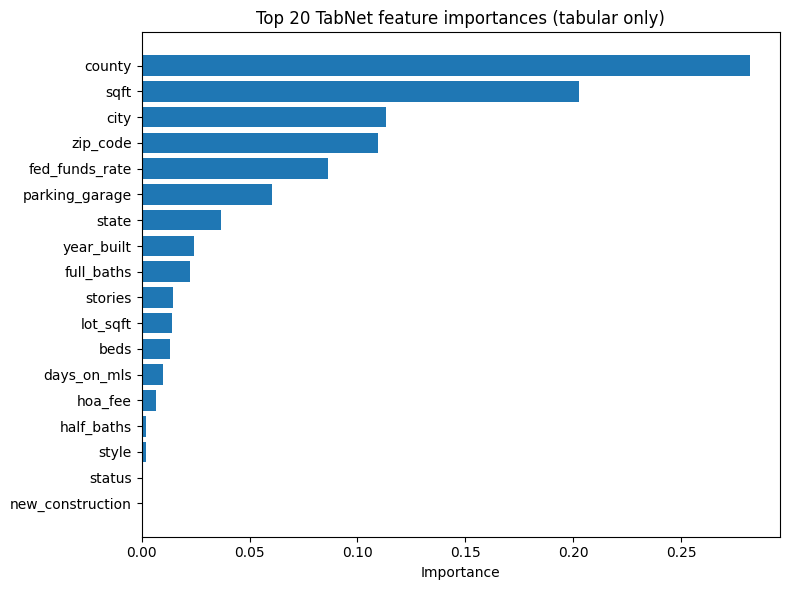

In [24]:
# Global feature importance from TabNet
fi = model.feature_importances_
fi_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": fi,
}).sort_values("importance", ascending=False)

print("Top 25 features by importance:")
display(fi_df.head(25))

# Simple bar plot
top_n = 20
top_fi = fi_df.head(top_n).iloc[::-1]  # reverse for top at bottom of barh

plt.figure(figsize=(8, 6))
plt.barh(top_fi["feature"], top_fi["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_n} TabNet feature importances (tabular only)")
plt.tight_layout()
plt.show()

# Local explainability (masks)
We can inspect attention masks for a few samples to understand which features were used by each decision step.


In [27]:
# Explain returns (M_explain, masks)
# masks: list of arrays [n_samples, n_features] per decision step
idx = np.random.choice(len(X_test), size=min(10, len(X_test)), replace=False)
X_small = X_test[idx]

M_explain, masks = model.explain(X_small)

print("M_explain shape:", M_explain.shape)
print("Num decision steps (masks):", len(masks))
print("Mask[0] shape:", masks[0].shape)

# Show top features for the first sample based on M_explain
s0 = M_explain[0]
topk = 20
top_idx = np.argsort(s0)[::-1][:topk]
pd.DataFrame({"feature": np.array(FEATURES)[top_idx], "local_importance": s0[top_idx]})

M_explain shape: (10, 18)
Num decision steps (masks): 5
Mask[0] shape: (10, 18)


,feature,local_importance
0,county,5.781696
1,sqft,4.677219
2,zip_code,2.597232
3,city,2.560712
4,parking_garage,1.809299
5,fed_funds_rate,1.674388
6,state,0.984633
7,year_built,0.718078
8,full_baths,0.421753
9,stories,0.272154
